In [2]:
from modules.polyfit import Polyfit
from modules.paramtune import Paramtune
import numpy as np
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import h5py

f = h5py.File('summer_data/inputdata.h5', "r")
bin_ids = np.array([x.decode() for x in f.get("index")[:]])
id_cut = np.array([sb[0] for sb in np.char.rsplit(bin_ids, "#", maxsplit=1)])

b = '/ATLAS_2019_I1736531/d'
e = '-x01-y01'

graph_spread = 0.1
density = 50

for i in jnp.arange(48, 54, 1):
    if i < 10:
        num_str = '0'+str(i)
    else:
        num_str = str(i)
    obs_id = b+num_str+e
    if(obs_id in id_cut):
        select_obs = np.array([obs_id])

        summer_fits = Polyfit('summer_data/fits.npz', input_h5='summer_data/inputdata.h5', order=3, covariance = True, cpu = True, reg_mode = "ridge_w", reg_param = 0.01, 
                            select_obs = select_obs)

        summer_tune_more_cov = Paramtune('summer_data/fits.npz', 'summer_data/HEPData-ins1736531-v1-csv.h5', covariance = True)

        target_values = jnp.load('obj_args/target_values.npy')
        target_error = jnp.load('obj_args/target_error.npy')
        coeffs = jnp.load('obj_args/coeffs.npy')
        coeff_cov = jnp.load('obj_args/coeff_cov.npy')
        target_binidns = jnp.load('obj_args/targ_bins.npy')

        p_opt = jnp.array(jnp.load('obj_args/p_opt.npy'))


        fits = summer_fits

        def objective_func(params, d, d_sig, coeff, cov):
            sum_over = 0
            poly = fits.vandermonde_jax(jnp.array([params]), fits.order)[0]
            norm = jnp.sum(fits.obs_weights)
            #Loop over the bins
            for i in target_binidns:
                f_sig = jnp.sqrt(jnp.matmul(poly, jnp.matmul(cov[i], poly.T))) #Finding uncertainty of surrogate function at point p
                adj_res_sq = fits.obs_weights[i]*(d[i]-jnp.matmul(coeff[i], poly.T))**2/(d_sig[i]**2 + f_sig**2) #Inner part of summation
                sum_over = sum_over + adj_res_sq
            return sum_over/norm

        def obj_mini(param):
            return objective_func(param, target_values, target_error, coeffs, coeff_cov)

        def Hessian(func):
            return jax.jacfwd(jax.jacrev(func))

        hess = Hessian(obj_mini)(p_opt)
        
        
        x = jnp.arange(p_opt[0]-graph_spread, p_opt[0]+graph_spread, 2*graph_spread/density)
        y = jnp.array([obj_mini(jnp.array([p])) for p in x])
        

        f = plt.figure()
        plt.plot(x, y)
        plt.axvline(p_opt[0])
        if jnp.isnan(hess)[0][0]:
            fil_nam = 'ZFAIL/'+num_str+'.png'
            fil_nam_coeff = 'ZZFAIL/'+num_str+'.npy'
            plt.savefig(fil_nam)
            jnp.save(fil_nam_coeff, coeffs)
        else:
            fil_nam = 'ZWORK/'+num_str+'.png'
            fil_nam_coeff = 'ZZWORK/'+num_str+'.npy'
            plt.savefig(fil_nam)
            jnp.save(fil_nam_coeff, coeffs)
        plt.clf
        plt.close(f)
    


Filtered 782 of 134343 total bins for invalid input
Fitting observables  ['/ATLAS_2019_I1736531/d48-x01-y01']
Only attempting to fit  50  out of  134343  bins.
Attempting to fit 50 of 50: /ATLAS_2019_I1736531/d48-x01-y01#49                         
 0  bins skipped for zeros.

Fits written to summer_data/fits.npz
loading  summer_data/fits.npz
Calculated inital guess:  [0.14152646]
Tuned Parameters:  [0.14128319] , Objective =  50.493347226733825 , chi2/ndf =  1.030476474014976
Using Hessian [[312249.44968375]]
Covariance of Tuned Parameters:  [[3.30017067e-06]]
Filtered 782 of 134343 total bins for invalid input
Fitting observables  ['/ATLAS_2019_I1736531/d49-x01-y01']
Only attempting to fit  50  out of  134343  bins.
Attempting to fit 49 of 50: /ATLAS_2019_I1736531/d49-x01-y01#48                         
Bin  48  identically zero across all runs, skipping!
Attempting to fit 50 of 50: /ATLAS_2019_I1736531/d49-x01-y01#49                         
 1  bins skipped for zeros.

Fits written

KeyboardInterrupt: 

target deviation 138.1546, with confidence level 0.6827, edof 131.0000


<bound method Polyfit.ridge_obj_w of <modules.polyfit.Polyfit object at 0x7faf680d33d0>>

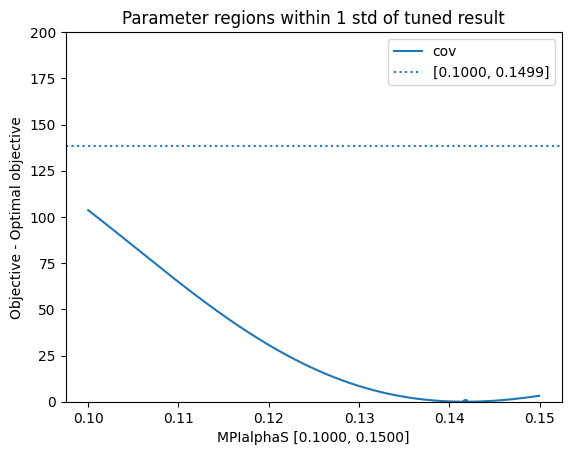

In [2]:
#summer_fits.graph_bin('/ATLAS_2019_I1736531/d01-x01-y01#3')

summer_tune_more_cov.graph_objective(graph_file = 'graph.pdf')


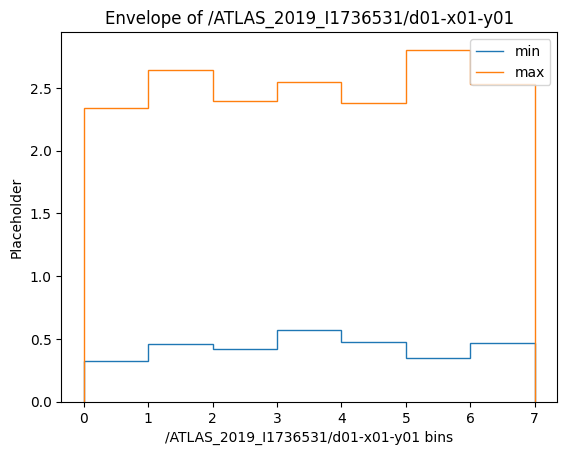

In [4]:
summer_fits.graph_envelope('/ATLAS_2019_I1736531/d01-x01-y01')

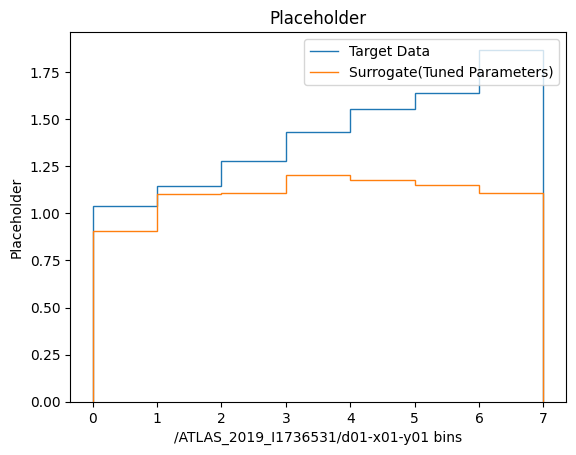

In [7]:
summer_tune_more_cov.graph_tune('/ATLAS_2019_I1736531/d01-x01-y01')